In [10]:
import os
import requests
import pandas as pd
import yfinance as yf

# Define the filename
FILE_NAME = "sp500_5y_prices.csv"

# Logic: Load local file if exists, otherwise download
if os.path.exists(FILE_NAME):
    print(f"Local file '{FILE_NAME}' found. Loading data...")
    # Read CSV (Ensure first column is parsed as Index/Date)
    prices = pd.read_csv(FILE_NAME, index_col=0)

else:
    print("Local file not found. Starting download pipeline...")
    
    # 1. Scrape Tickers
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    tickers = pd.read_html(html)[0]['Symbol'].str.replace('.', '-', regex=False).tolist()

    # 2. Batch Download
    print(f"Downloading {len(tickers)} stocks...")
    data = yf.download(tickers, period="5y", auto_adjust=True)

    # 3. Extract & Clean
    prices = data['Close'] if 'Close' in data.columns else data
    prices = prices.dropna(axis=1, how='all')

    # 4. Save to CSV
    prices.to_csv(FILE_NAME)
    print("Download complete and saved.")

print(f"Data ready. Shape: {prices.shape}")


Local file not found. Starting download pipeline...


/tmp/ipython-input-2654015509.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tickers = pd.read_html(html)[0]['Symbol'].str.replace('.', '-', regex=False).tolist()
[*********************100%***********************]  503 of 503 completed


Download complete and saved.
Data ready. Shape: (1255, 503)


In [11]:
#Save plots function
import os
import matplotlib.pyplot as plt

def save_graph(filename, folder="plots"):
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    path = f"{folder}/{filename}.png"
    plt.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Image saved successfully to: {path}")

In [ ]:
# if running with Colab GPU 
# !pip install --quiet torch_geometric -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

import torch
from torch_geometric.nn import GCNConv

# --- 1. Load Data & Preprocess ---
# Read the CSV file we just downloaded
df = pd.read_csv("sp500_5y_prices.csv", index_col=0)
# Calculate daily returns (Change from yesterday)
returns = df.pct_change().dropna()

# --- 2. Build Graph (The "Structure") ---
# Calculate Correlation Matrix (How similar are the stocks?)
# .T ensures stocks are columns for corr computation if needed, but usually df structure is (Date, Ticker)
corr_matrix = torch.tensor(returns.corr().values)

# Define Edges: Connect stocks if absolute correlation > 0.6
# This creates the "Adjacency Matrix" in sparse format
edge_index = (corr_matrix.abs() > 0.6).nonzero().t()

# --- 3. Define Minimalist GCN Model ---
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super().__init__()
        # Layer 1: Look at immediate neighbors
        self.conv1 = GCNConv(in_features, hidden_dim)
        # Layer 2: Look at neighbors of neighbors
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        # Layer 1 -> ReLU Activation (Non-linearity)
        x = self.conv1(x, edge_index).relu()
        # Layer 2 -> Final Output
        x = self.conv2(x, edge_index)
        return x

# --- 4. Execution (Run the model) ---
# Prepare Input Features (Node Features)
# We take the VERY LAST day's returns as input. Shape: [Num_Stocks, 1]
x = torch.tensor(returns.iloc[-1].values, dtype=torch.float).view(-1, 1)

# Initialize Model (1 Input -> 16 Hidden -> 1 Output)
model = GCN(in_features=1, hidden_dim=16, out_features=1)

# Forward Pass (The Magic Happens Here)
output = model(x, edge_index)

# --- 5. Report ---
print("-" * 30)
print(f"Graph Statistics:")
print(f"  - Nodes (Stocks): {x.shape[0]}")
print(f"  - Edges (Connections): {edge_index.shape[1]}")
print(f"  - Edge Density: {edge_index.shape[1] / (x.shape[0]**2):.4f}")
print("\nModel Architecture:")
print(model)
print(f"\nOutput Shape: {output.shape}") # Should be [Num_Stocks, 1]
print("Success: GCN forward pass completed.")
print("-" * 30)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00
------------------------------
Graph Statistics:
  - Nodes (Stocks): 503
  - Edges (Connections): 2877
  - Edge Density: 0.0114

Model Architecture:
GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 1)
)

Output Shape: torch.Size([503, 1])
Success: GCN forward pass completed.
------------------------------


/tmp/ipython-input-220206448.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change().dropna()


Created folder: plots
Image saved successfully to: plots/S&P 500 Correlation Network (First 100).png


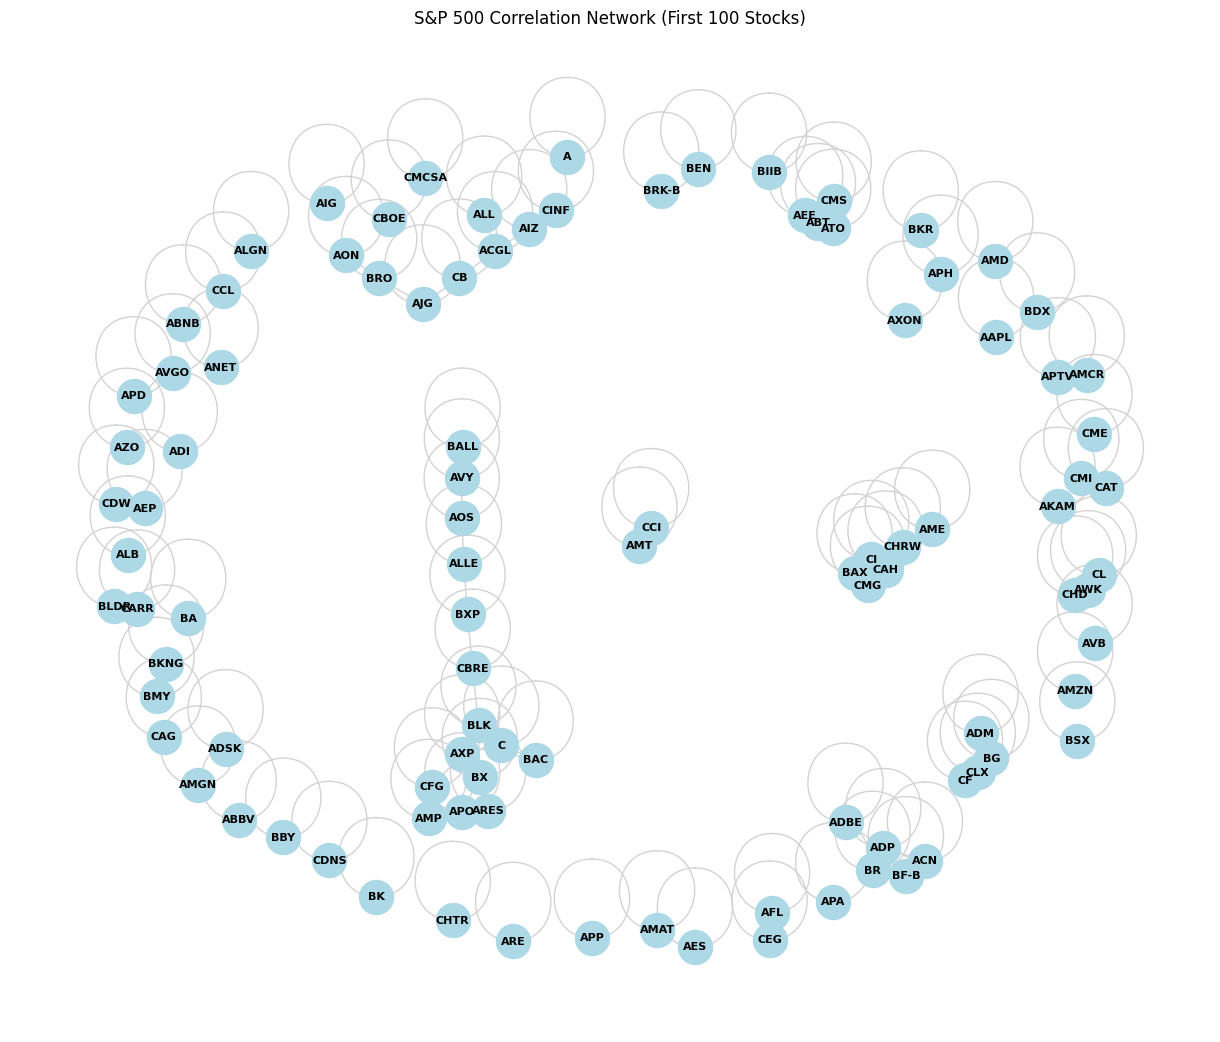

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

#First 100 stock
# Get the list of stock symbols from the dataframe columns
ticker_names = returns.columns.tolist()

# Define subset (First 100 stocks) to keep plot readable
limit = 100
sub_nodes = range(limit)
sub_edges = edge_index[:, (edge_index[0] < limit) & (edge_index[1] < limit)]

# 2. Build Graph Object
g = nx.Graph()
g.add_nodes_from(sub_nodes)
g.add_edges_from(sub_edges.t().tolist())

# 3. Create Label Mapping (Index -> Ticker Name)
# This dictionary maps integer ID (e.g., 0) to Ticker (e.g., 'A')
label_map = {i: ticker_names[i] for i in sub_nodes}

# 4. Plotting
plt.figure(figsize=(12, 10)) # Increased size for better readability
# k=0.15 controls node spacing (larger k = more spread out)
pos = nx.spring_layout(g, seed=42, k=0.15) 

nx.draw(g, pos, 
        node_size=600, 
        node_color='lightblue', 
        edge_color='lightgray', 
        with_labels=True, 
        labels=label_map, # Apply the ticker names here
        font_size=8, 
        font_weight='bold')

plt.title(f"S&P 500 Correlation Network (First {limit} Stocks)")
save_graph("S&P 500 Correlation Network (First 100)")
plt.show()

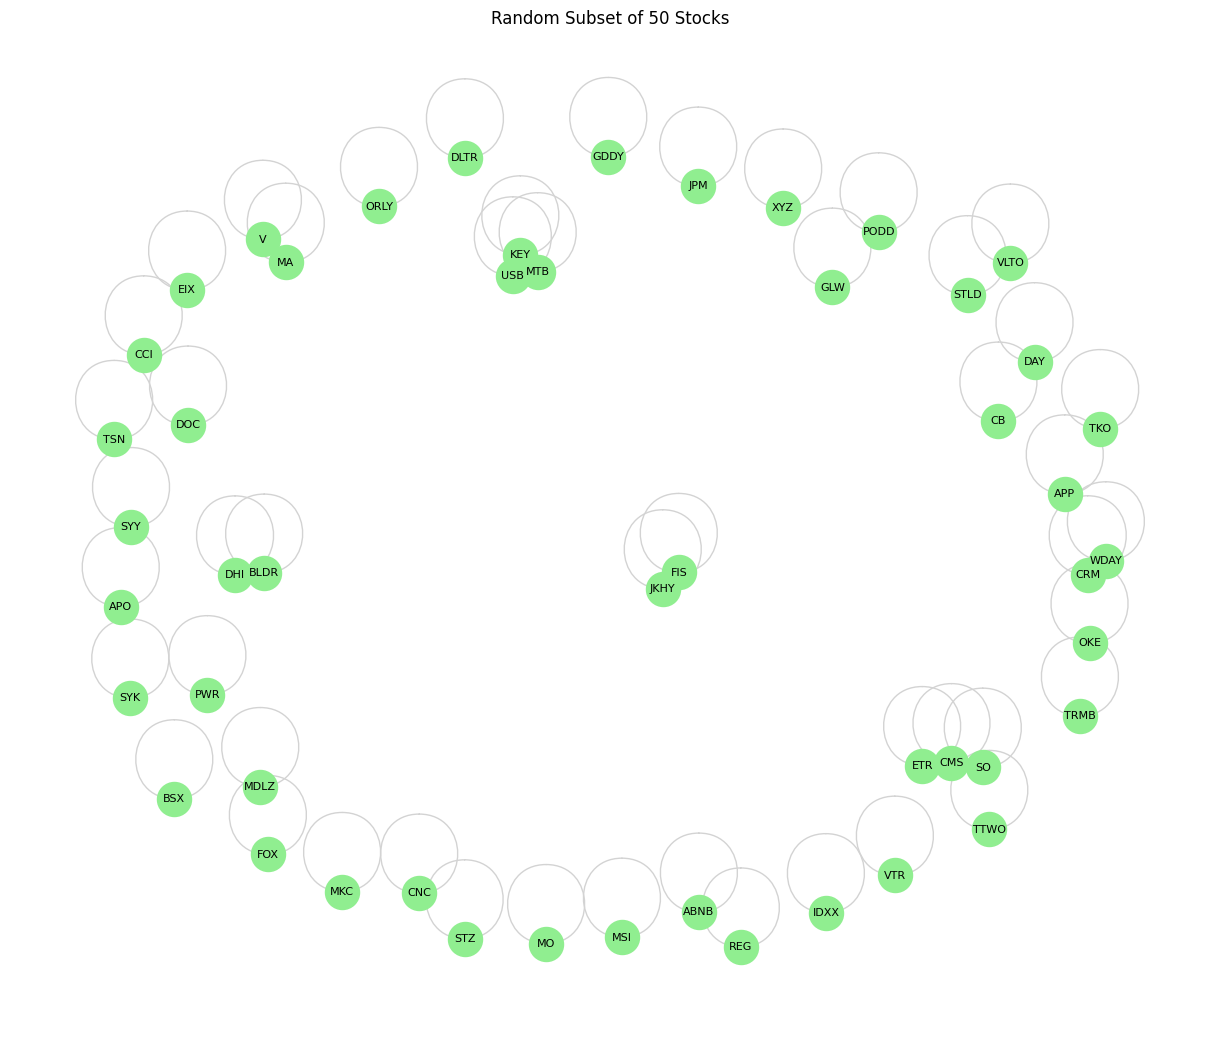

In [18]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Random 50 stocks
num_sample = 50  
# Get total number of stocks
num_total = len(returns.columns)

# Randomly pick 50 indices from 0 to 500
selected_indices = np.random.choice(num_total, num_sample, replace=False)
sub_nodes = selected_indices # These are the node IDs (e.g., [5, 120, 303...])

# --- 2. Filter Edges (The Logic Change) ---
# We need edges where BOTH source AND target are in our random selection
# torch.isin checks if elements are in the test list
mask = torch.isin(edge_index[0], torch.tensor(sub_nodes)) & \
       torch.isin(edge_index[1], torch.tensor(sub_nodes))

sub_edges = edge_index[:, mask]

# --- 3. Build Graph ---
g = nx.Graph()
g.add_nodes_from(sub_nodes)
g.add_edges_from(sub_edges.t().tolist())

# --- 4. Map Labels (Map ID -> Ticker) ---
ticker_names = returns.columns.tolist()
label_map = {i: ticker_names[i] for i in sub_nodes}

# --- 5. Plot ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(g, seed=42, k=0.15) # k controls spacing

nx.draw(g, pos, 
        node_size=600, 
        node_color='lightgreen', # Changed color to indicate random
        edge_color='lightgray', 
        with_labels=True, 
        labels=label_map,
        font_size=8)

plt.title(f"Random Subset of {num_sample} Stocks")
plt.show()

Image saved successfully to: plots/sp500_all_corr.png


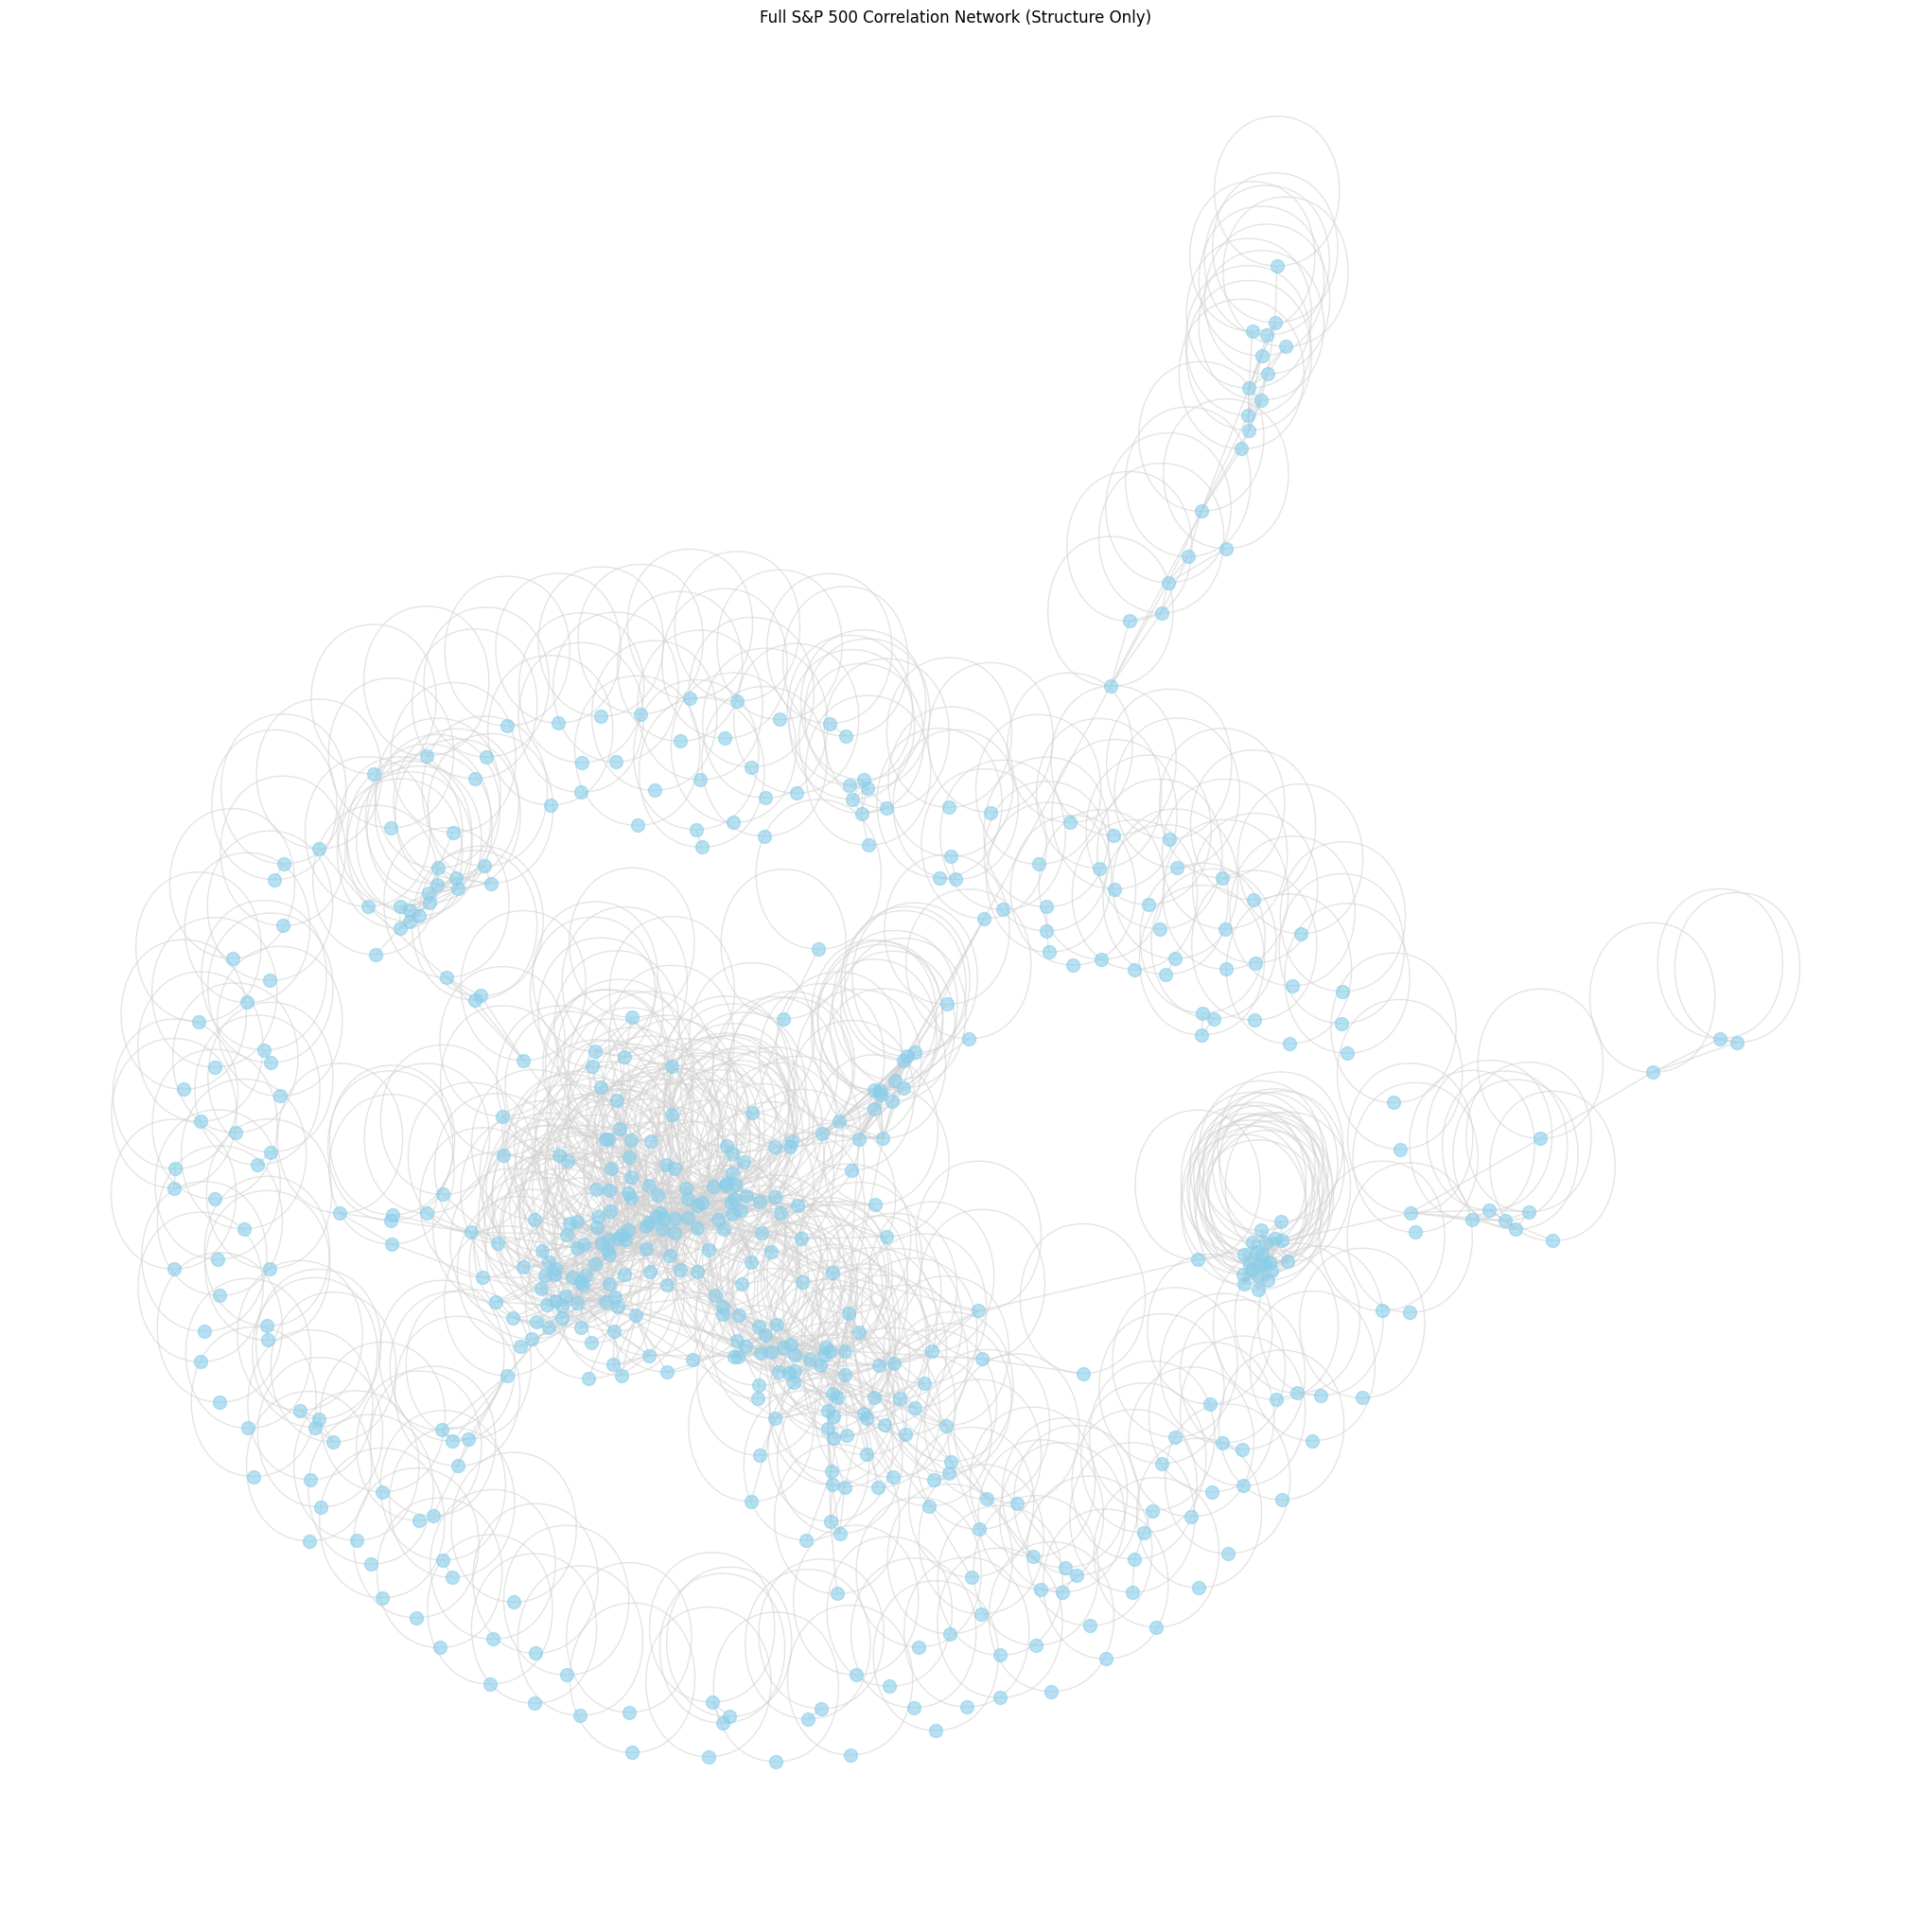

In [ ]:
# All Stocks
all_nodes = range(len(returns.columns))
all_edges = edge_index # No filtering needed

# --- Build Graph ---
g = nx.Graph()
g.add_nodes_from(all_nodes)
g.add_edges_from(all_edges.t().tolist())

# --- Map Labels ---
ticker_names = returns.columns.tolist()
label_map = {i: ticker_names[i] for i in all_nodes}

# --- Plot ---
plt.figure(figsize=(20, 20)) # Must increase canvas size drastically!
# k=0.05: Make nodes pull tighter together to fit in screen
pos = nx.spring_layout(g, seed=42, k=0.05) 

nx.draw(g, pos, 
        node_size=100, # Make nodes smaller
        node_color='skyblue', 
        edge_color='lightgray', 
        with_labels=False, # Turn OFF labels (too messy for 500 nodes)
        alpha=0.6)

plt.title("Full S&P 500 Correlation Network (Structure Only)")
save_graph("sp500_all_corr")
plt.show()

Top 10 Most Connected Stocks (The Market Hubs):
1. SWK (Connections: 43)
2. ITW (Connections: 34)
3. WAB (Connections: 33)
4. MAS (Connections: 31)
5. CFG (Connections: 30)
6. DOV (Connections: 29)
7. USB (Connections: 28)
8. TFC (Connections: 28)
9. RF (Connections: 28)
10. PHM (Connections: 23)
Image saved successfully to: plots/top10_hubs_network.png


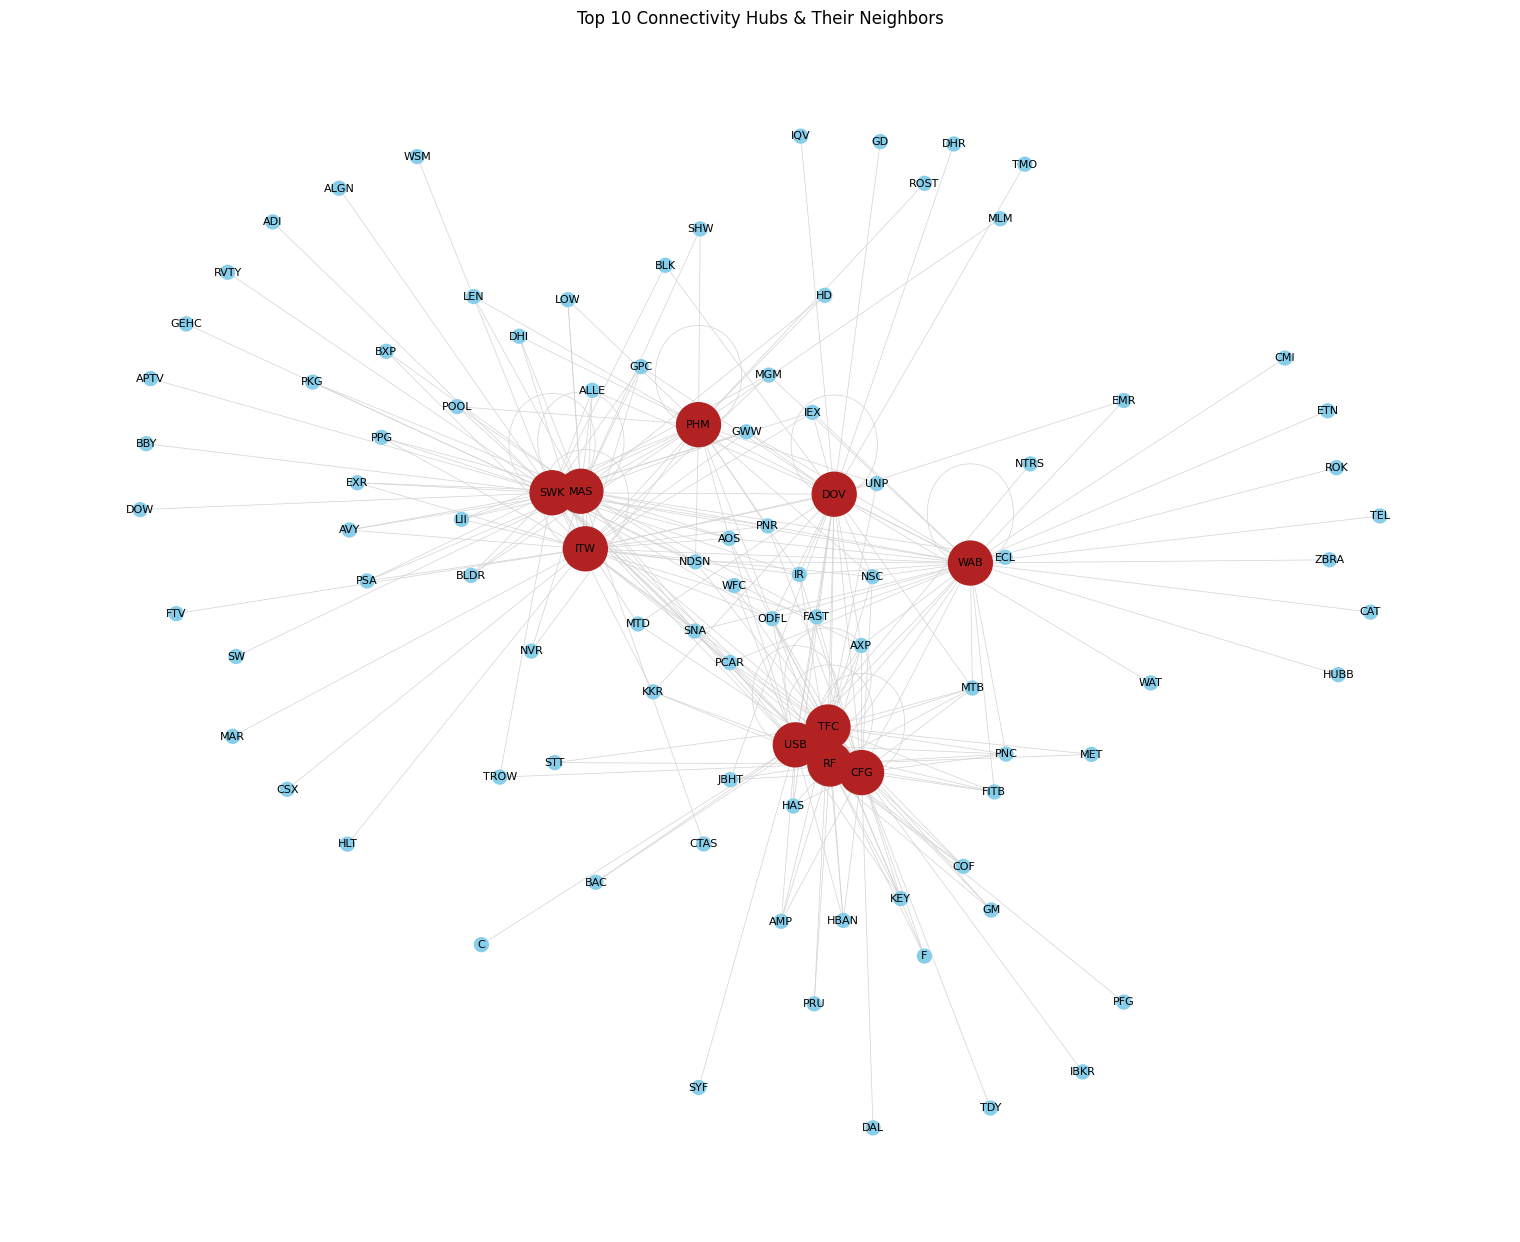

In [ ]:
#Top 10 "Hub" Stocks

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import degree

# Calculate degree (number of edges) for each node
d = degree(edge_index[0], dtype=torch.long)

# Get indices of the top 10 highest degree nodes
k = 10
top_values, top_nodes_tensor = torch.topk(d, k)
top_nodes = top_nodes_tensor.tolist()

# Print who they are
ticker_names = returns.columns.tolist()
print("Top 10 Most Connected Stocks (The Market Hubs):")
for i, idx in enumerate(top_nodes):
    print(f"{i+1}. {ticker_names[idx]} (Connections: {top_values[i].item()})")

# --- 2. Extract Subgraph (Top 10 + Their Neighbors) ---
# We keep an edge if EITHER source OR target is in the Top 10
mask = torch.isin(edge_index[0], top_nodes_tensor) | \
       torch.isin(edge_index[1], top_nodes_tensor)

sub_edges = edge_index[:, mask]

# Get all unique nodes in this subgraph (Hubs + Neighbors)
unique_nodes = torch.unique(sub_edges).tolist()

# --- 3. Visualization Setup ---
g = nx.Graph()
g.add_nodes_from(unique_nodes)
g.add_edges_from(sub_edges.t().tolist())

# Map ID to Ticker
label_map = {i: ticker_names[i] for i in unique_nodes}

# Define Colors & Sizes based on role
# Red/Large for Top 10, Blue/Small for others
node_colors = ['firebrick' if i in top_nodes else 'skyblue' for i in unique_nodes]
node_sizes = [1000 if i in top_nodes else 100 for i in unique_nodes]

# --- 4. Plot ---
plt.figure(figsize=(15, 12))
# Use Kamada-Kawai layout (good for visualizing central hubs)
pos = nx.spring_layout(g, seed=42, k=0.15)

nx.draw(g, pos, 
        node_color=node_colors, 
        node_size=node_sizes, 
        with_labels=True, 
        labels=label_map,
        edge_color='lightgray',
        font_size=8,
        width=0.5)

plt.title(f"Top {k} Connectivity Hubs & Their Neighbors")
save_graph("top10_hubs_network")
plt.show()

Embedding Shape: (503, 16)
Image saved successfully to: plots/gnn_tsne_embedding.png


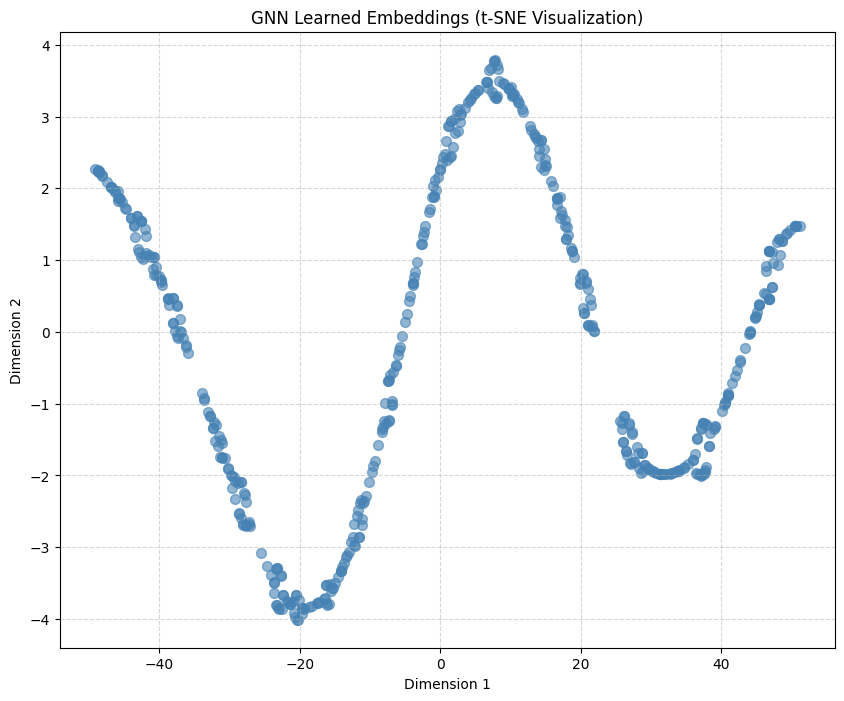

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract Embeddings (The "Brain" State)
# We want the output of the FIRST layer (16-dimensional), not the final prediction
# Detach removes it from the computational graph so we can plot it
embeddings = model.conv1(x, edge_index).detach().numpy()

print(f"Embedding Shape: {embeddings.shape}") # Should be (502, 16)

# 2. Reduce Dimensions (16D -> 2D) using t-SNE
# perplexity=30 is standard. It determines how many neighbors to consider.
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Visualization
plt.figure(figsize=(10, 8))
# Plot all points
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50, c='steelblue')

# Optional: Annotate a few famous tech stocks if they are in the list
# (This assumes you know their index, for now we just plot the structure)
plt.title("GNN Learned Embeddings (t-SNE Visualization)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)
save_graph("gnn_tsne_embedding")
plt.show()

In [ ]:
#Imports & load events
import numpy as np, pandas as pd, torch
from pathlib import Path
from sentence_transformers import SentenceTransformer

events_path = Path("news_events.parquet")
events = pd.read_parquet("news_events.parquet")
events["text"] = events["text"].fillna("").str.replace(r"\s+", " ", regex=True).str.strip()
print("Events shape:", events.shape)


Events shape: (480, 9)


In [ ]:
# Model config (auto-cache-or-download)
from pathlib import Path
from sentence_transformers import SentenceTransformer
import torch, os

# if exists use local path, else download from Huggingface
cached = Path.home() / ".cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2"
model_id = str(cached) if cached.exists() else "all-MiniLM-L6-v2"

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_id, device=device, local_files_only=False)  
print("Using model:", model_id)
print("Device:", device)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using model: all-MiniLM-L6-v2
Device: cpu


In [ ]:
# Batch encode
batch_size = 64
texts = events["text"].tolist()
emb_list = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    with torch.inference_mode():
        emb = model.encode(batch, batch_size=len(batch), show_progress_bar=False, normalize_embeddings=True)
    emb_list.append(emb)
emb = np.vstack(emb_list).astype(np.float16)
print("Embedding shape:", emb.shape)


Embedding shape: (480, 384)


In [ ]:
#Save embeddings + meta
np.save("news_events_emb.npy", emb)
meta = events[["doc_id", "ticker", "date", "label", "return_next"]].copy()
meta["text_idx"] = np.arange(len(events))
meta.to_parquet("news_events_emb_meta.parquet", index=False)
print("Saved news_events_emb.npy and news_events_emb_meta.parquet")


Saved news_events_emb.npy and news_events_emb_meta.parquet


In [ ]:
# embeddings Integrity checks
loaded_emb = np.load("news_events_emb.npy")
loaded_meta = pd.read_parquet("news_events_emb_meta.parquet")
print("Row count match:", loaded_emb.shape[0] == len(loaded_meta))
print("NaN in emb:", np.isnan(loaded_emb).any())
print("NaN in meta:", loaded_meta.isna().any().to_dict())
print("Label distribution:", loaded_meta["label"].value_counts(normalize=True))
print("Rows per ticker:", loaded_meta["ticker"].value_counts().to_dict())


Row count match: True
NaN in emb: False
NaN in meta: {'doc_id': False, 'ticker': False, 'date': False, 'label': False, 'return_next': False, 'text_idx': False}
Label distribution: label
0    0.508333
1    0.491667
Name: proportion, dtype: float64
Rows per ticker: {'CFG': 102, 'TFC': 102, 'FITB': 67, 'HBAN': 59, 'RF': 49, 'WAB': 42, 'ITW': 34, 'IR': 15, 'DOV': 10}


In [ ]:
# Baseline Logistic Regression

import pandas as pd
import numpy as np
import torch
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from torch_geometric.data import HeteroData

# --- 1. Load data ---
print("Loading data...")
emb = np.load("news_events_emb.npy").astype(np.float32)
meta = pd.read_parquet("news_events_emb_meta.parquet")

print(f"Embeddings shape: {emb.shape}")
print(f"Metadata shape:   {meta.shape}")

# Ensure time order
meta = meta.sort_values("date").reset_index(drop=True)
if "text_idx" in meta.columns:
    emb = emb[meta["text_idx"].values]

# --- 2. Time-series split (strict by calendar dates) ---
meta = meta.sort_values("date").reset_index(drop=True)
if "text_idx" in meta.columns:
    emb = emb[meta["text_idx"].values]

dates = meta["date"]
t80 = dates.iloc[int(len(dates) * 0.8)]
t90 = dates.iloc[int(len(dates) * 0.9)]

train_mask = (dates <= t80).to_numpy()
val_mask   = ((dates > t80) & (dates <= t90)).to_numpy()
test_mask  = (dates > t90).to_numpy()

print(train_mask.sum(), val_mask.sum(), test_mask.sum())


# --- 3. Baseline: Logistic Regression on text only ---
print("\n--- Baseline (LogReg on embeddings) ---")
X = emb
y = meta["label"].values

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

clf = LogisticRegression(
    class_weight="balanced",
    solver="saga",
    penalty= "l2",
    C=2.0,
    max_iter=500,
    n_jobs=1,  # keep memory/thread footprint small
)
clf.fit(X_train, y_train)

def eval_split(name, Xs, ys):
    prob = clf.predict_proba(Xs)[:, 1]
    pred = (prob >= 0.5).astype(int)
    print(f"{name} AUC: {roc_auc_score(ys, prob):.4f}")
    print(f"{name} report:\n", classification_report(ys, pred, digits=4))

eval_split("Val", X_val, y_val)
eval_split("Test", X_test, y_test)

# --- 4. Build HeteroData for GNN ---
print("\n--- Building HeteroData ---")
unique_tickers = meta["ticker"].unique()
ticker_to_id = {t: i for i, t in enumerate(unique_tickers)}
meta["ticker_id"] = meta["ticker"].map(ticker_to_id)

num_news = len(meta)
num_stocks = len(unique_tickers)

data = HeteroData()

# News nodes
data["news"].x = torch.from_numpy(emb)
data["news"].y = torch.from_numpy(y).long()
data["news"].train_mask = torch.from_numpy(train_mask)
data["news"].val_mask   = torch.from_numpy(val_mask)
data["news"].test_mask  = torch.from_numpy(test_mask)

# Stock nodes (placeholder one-hot; replace with price features later)
data["stock"].x = torch.eye(num_stocks)
data["stock"].ticker_map = unique_tickers  # for reference

# Edges: news -> stock
src = torch.arange(num_news)
dst = torch.from_numpy(meta["ticker_id"].to_numpy())
data["news", "relates_to", "stock"].edge_index = torch.stack([src, dst], dim=0)

print(data)
print(f"News nodes:  {data['news'].num_nodes}")
print(f"Stock nodes: {data['stock'].num_nodes}")
print(f"Edges:       {data['news', 'relates_to', 'stock'].num_edges}")

torch.save(data, "graph_data.pt")
print("\nGraph saved to graph_data.pt (ready for GNN).")


Loading data...
Embeddings shape: (480, 384)
Metadata shape:   (480, 6)
385 48 47

--- Baseline (LogReg on embeddings) ---
Val AUC: 0.5165
Val report:
               precision    recall  f1-score   support

           0     0.4783    0.4583    0.4681        24
           1     0.4800    0.5000    0.4898        24

    accuracy                         0.4792        48
   macro avg     0.4791    0.4792    0.4789        48
weighted avg     0.4791    0.4792    0.4789        48

Test AUC: 0.6213
Test report:
               precision    recall  f1-score   support

           0     0.7368    0.5185    0.6087        27
           1     0.5357    0.7500    0.6250        20

    accuracy                         0.6170        47
   macro avg     0.6363    0.6343    0.6168        47
weighted avg     0.6513    0.6170    0.6156        47


--- Building HeteroData ---
HeteroData(
  news={
    x=[480, 384],
    y=[480],
    train_mask=[480],
    val_mask=[480],
    test_mask=[480],
  },
  stock={
    

In [31]:
#Pytorch Geometric GraphSAGE
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from sklearn.metrics import roc_auc_score

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load graph and add reverse edges for bidirectional message passing
data = torch.load("graph_data.pt")
data = T.ToUndirected()(data).to(device)

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels=32, out_channels=1):
        super().__init__()
        # Two-layer GraphSAGE; -1 lets PyG infer input dims per node type
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)  # moderate dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.lin(x)

# Convert to heterogeneous version with mean aggregation
model = to_hetero(GNN(), data.metadata(), aggr='mean').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

def train_step():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out['news'][data['news'].train_mask]
    target = data['news'].y[data['news'].train_mask].float().unsqueeze(1)
    loss = criterion(pred, target)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_auc(mask):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out['news'][mask]
    target = data['news'].y[mask].float().unsqueeze(1)
    prob = pred.sigmoid().cpu().numpy()
    target_np = target.cpu().numpy()
    try:
        return roc_auc_score(target_np, prob)
    except ValueError:
        return 0.5  # fallback if only one class


#early stopping
best_val = 0
best_state = None
patience = 15
stale = 0
for epoch in range(1, 201):
    loss = train_step()
    val_auc = eval_auc(data['news'].val_mask)
    test_auc = eval_auc(data['news'].test_mask)
    if val_auc > best_val:
        best_val = val_auc
        best_test = test_auc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        stale = 0
    else:
        stale += 1
    if stale >= patience:
        print(f"Early stop at epoch {epoch}, best Val AUC {best_val:.4f}")
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss {loss:.4f} | Val AUC {val_auc:.4f} | Test AUC {test_auc:.4f}")
# load best
if best_state:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print(f"Best Val AUC: {best_val:.4f} | Test AUC @best: {best_test:.4f}")



/Users/heruixi/anaconda3/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:120: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  return transformer.transform()


Epoch 010 | Loss 0.6737 | Val AUC 0.4583 | Test AUC 0.6981
Epoch 020 | Loss 0.6298 | Val AUC 0.4705 | Test AUC 0.7352
Early stop at epoch 24, best Val AUC 0.6285
Best Val AUC: 0.6285 | Test AUC @best: 0.6537
